# Desafio 6

Neste desafio, vamos praticar _feature engineering_, um dos processos mais importantes e trabalhosos de ML. Utilizaremos o _data set_ [Countries of the world](https://www.kaggle.com/fernandol/countries-of-the-world), que contém dados sobre os 227 países do mundo com informações sobre tamanho da população, área, imigração e setores de produção.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
import scipy.stats as sct

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from math import sqrt, log

In [4]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [5]:
countries = pd.read_csv("countries.csv")

In [6]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

countries.columns = new_column_names

countries.head(5)

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


## Observações

Esse _data set_ ainda precisa de alguns ajustes iniciais. Primeiro, note que as variáveis numéricas estão usando vírgula como separador decimal e estão codificadas como strings. Corrija isso antes de continuar: transforme essas variáveis em numéricas adequadamente.

Além disso, as variáveis `Country` e `Region` possuem espaços a mais no começo e no final da string. Você pode utilizar o método `str.strip()` para remover esses espaços.

## Inicia sua análise a partir daqui

In [7]:
# Sua análise começa aqui.

#Criação do dataset auxiliar para análise inicial dos dados
df_aux = pd.DataFrame({
                    'Columns': countries.columns,
                    'Type': countries.dtypes,
                    'Nan': countries.isnull().sum()
                    })
df_aux['Nan%'] = round(df_aux.Nan/countries.shape[0]*100,2)
df_aux

,Columns,Type,Nan,Nan%
Country,Country,object,0,0.00
Region,Region,object,0,0.00
Population,Population,int64,0,0.00
Area,Area,int64,0,0.00
Pop_density,Pop_density,object,0,0.00
Coastline_ratio,Coastline_ratio,object,0,0.00
Net_migration,Net_migration,object,3,1.32
Infant_mortality,Infant_mortality,object,3,1.32
GDP,GDP,float64,1,0.44
Literacy,Literacy,object,18,7.93


In [8]:
#por apresentar poucos valores distintos Climate poderia ser considerada uma variável categórica
countries.Climate.value_counts()

2      111
3       48
1       29
1,5      8
4        6
2,5      3
Name: Climate, dtype: int64

In [9]:
col = ['Pop_density', 'Coastline_ratio', 'Net_migration', 'Infant_mortality',
       'Literacy', 'Phones_per_1000', 'Arable', 'Crops', 'Other','Climate',
       'Birthrate', 'Deathrate', 'Agriculture', 'Industry', 'Service']

In [10]:
# nas colunas que devem ser transformadas em numéricas
# substitui a virgula por ponto
# convert de string para float

def replace(x):
    if pd.isnull(x):
        pass
    else:
        x = x.replace(',','.')
        x = float(x)
    return x
            
for i in col:
    countries[i] = list(map(replace, countries[i] ))

## Análise Questão 1

In [11]:
# identificando espaços nas colunas Country e Region
countries.Country[0]

'Afghanistan '

In [12]:
countries.Region[0]

'ASIA (EX. NEAR EAST)         '

In [13]:
# remove espaços em branco no começo e no final da string
# caso fosse remover somente em uma das posições lstrip() rstrip()
# como a string é imutável, é necessário que outra variável receba seu valor
countries['Country'] = countries['Country'].str.strip()
countries['Region'] = countries['Region'].str.strip()

In [14]:
sorted(countries.Region.value_counts().index.tolist()) 

['ASIA (EX. NEAR EAST)',
 'BALTICS',
 'C.W. OF IND. STATES',
 'EASTERN EUROPE',
 'LATIN AMER. & CARIB',
 'NEAR EAST',
 'NORTHERN AFRICA',
 'NORTHERN AMERICA',
 'OCEANIA',
 'SUB-SAHARAN AFRICA',
 'WESTERN EUROPE']

## Análise questão 2

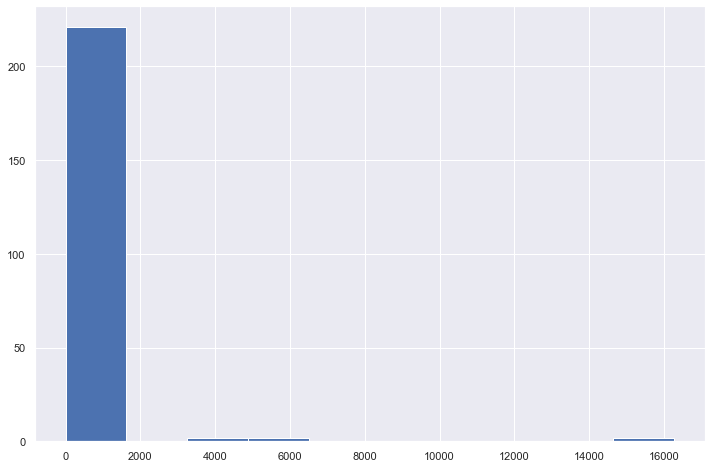

In [15]:
countries.Pop_density.hist()

In [16]:
# existem apenas dois registros nos intervalos acima maiores que 2000
countries[countries.Pop_density>2000]

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
74,Gaza Strip,NEAR EAST,1428757,360,3968.8,11.11,1.60,22.93,600.0,NaN,244.3,28.95,21.05,50.00,3.0,39.45,3.80,0.030,0.283,0.687
78,Gibraltar,WESTERN EUROPE,27928,7,3989.7,171.43,0.00,5.13,17500.0,NaN,877.7,0.00,0.00,100.00,NaN,10.74,9.31,NaN,NaN,NaN
91,Hong Kong,ASIA (EX. NEAR EAST),6940432,1092,6355.7,67.12,5.24,2.97,28800.0,93.5,546.7,5.05,1.01,93.94,2.0,7.29,6.29,0.001,0.092,0.906
122,Macau,ASIA (EX. NEAR EAST),453125,28,16183.0,146.43,4.86,4.39,19400.0,94.5,384.9,0.00,0.00,100.00,2.0,8.48,4.47,0.001,0.072,0.927
138,Monaco,WESTERN EUROPE,32543,2,16271.5,205.00,7.75,5.43,27000.0,99.0,1035.6,0.00,0.00,100.00,NaN,9.19,12.91,0.170,NaN,NaN
184,Singapore,ASIA (EX. NEAR EAST),4492150,693,6482.2,27.85,11.53,2.29,23700.0,92.5,411.4,1.64,0.00,98.36,2.0,9.34,4.28,0.000,0.339,0.661


In [17]:
#Criação de variável que representa intevalos, semelhante ao pd.cut
discretizer = preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
discretizer.fit(countries[['Pop_density']])

KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='quantile')

In [18]:
# limites para cada range
discretizer.bin_edges_

array([array([0.00000e+00, 1.01400e+01, 2.12200e+01, 3.94800e+01, 5.98000e+01,
       7.88000e+01, 1.05540e+02, 1.50120e+02, 2.53700e+02, 3.96740e+02,
       1.62715e+04])], dtype=object)

In [19]:
# numericamente representa em qual intervalo ficara cada linha
score_bins = discretizer.transform(countries[['Pop_density']])

In [20]:
score_bins[:,0]

array([3., 6., 1., 8., 7., 0., 6., 7., 1., 5., 8., 0., 5., 5., 2., 9., 9.,
       9., 3., 8., 1., 4., 9., 3., 0., 5., 0., 2., 7., 4., 4., 3., 4., 8.,
       4., 2., 0., 5., 7., 0., 0., 2., 6., 2., 8., 2., 1., 5., 5., 3., 5.,
       5., 5., 6., 6., 1., 5., 7., 4., 3., 5., 8., 1., 3., 2., 4., 2., 3.,
       1., 6., 0., 4., 0., 6., 9., 4., 7., 5., 9., 5., 0., 8., 8., 8., 6.,
       9., 2., 3., 0., 8., 4., 9., 6., 0., 8., 6., 3., 4., 3., 6., 8., 7.,
       7., 8., 9., 4., 0., 3., 6., 7., 9., 6., 2., 2., 2., 8., 4., 2., 0.,
       7., 3., 7., 9., 5., 2., 6., 4., 9., 0., 9., 0., 8., 0., 9., 9., 3.,
       7., 6., 9., 0., 5., 4., 2., 0., 9., 7., 9., 7., 1., 1., 3., 0., 6.,
       7., 1., 1., 7., 3., 3., 1., 1., 2., 8., 6., 6., 8., 4., 8., 5., 0.,
       8., 1., 6., 8., 2., 8., 4., 9., 7., 1., 4., 6., 7., 5., 9., 6., 5.,
       1., 1., 2., 5., 8., 1., 0., 4., 1., 7., 5., 9., 3., 3., 6., 5., 7.,
       7., 4., 5., 1., 3., 9., 6., 4., 2., 7., 2., 1., 4., 1., 2., 8., 3.,
       3., 9., 0., 3., 1.

In [21]:
bin_edges_quantile = discretizer.bin_edges_[0]
len(bin_edges_quantile)

11

In [22]:
#lista a quantidade de registros por intervalo de 'Pop_density'
#cada intervalo contém 10% dos registros
def get_intervals(bin_idx, bin_edge):
    return f"{np.round(bin_edge[bin_idx],2):.2f} to {np.round(bin_edge[bin_idx+1],2):.2f}"

for i in range(len(bin_edges_quantile) -1):
    print(f"{get_intervals(i, bin_edges_quantile)} : qtde registros {sum(score_bins[:,0] == i)} ")

0.00 to 10.14 : qtde registros 23 
10.14 to 21.22 : qtde registros 23 
21.22 to 39.48 : qtde registros 22 
39.48 to 59.80 : qtde registros 23 
59.80 to 78.80 : qtde registros 22 
78.80 to 105.54 : qtde registros 23 
105.54 to 150.12 : qtde registros 23 
150.12 to 253.70 : qtde registros 22 
253.70 to 396.74 : qtde registros 23 
396.74 to 16271.50 : qtde registros 23 


In [23]:
#considerando que cada linha é um país
#a quantidade de paises que se encontram acima de 90 percentil
sum(score_bins[:,0]>=9)

23

## Análise questão 3

In [24]:
#quantidade de registros por Region
countries.Region.value_counts()

SUB-SAHARAN AFRICA      51
LATIN AMER. & CARIB     45
ASIA (EX. NEAR EAST)    28
WESTERN EUROPE          28
OCEANIA                 21
NEAR EAST               16
EASTERN EUROPE          12
C.W. OF IND. STATES     12
NORTHERN AFRICA          6
NORTHERN AMERICA         5
BALTICS                  3
Name: Region, dtype: int64

In [25]:
#quantidade de registros por Climate
countries.Climate.value_counts(dropna=False)

2.0    111
3.0     48
1.0     29
NaN     22
1.5      8
4.0      6
2.5      3
Name: Climate, dtype: int64

In [26]:
#registros cujo Climate esta nan
countries[countries['Climate'].isnull()]

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
5,Angola,SUB-SAHARAN AFRICA,12127071,1246700,9.7,0.13,0.00,191.19,1900.0,42.0,7.8,2.41,0.24,97.35,NaN,45.11,24.20,0.096,0.658,0.246
36,Canada,NORTHERN AMERICA,33098932,9984670,3.3,2.02,5.96,4.75,29800.0,97.0,552.2,4.96,0.02,95.02,NaN,10.78,7.80,0.022,0.294,0.684
50,Croatia,EASTERN EUROPE,4494749,56542,79.5,10.32,1.58,6.84,10600.0,98.5,420.4,26.09,2.27,71.65,NaN,9.61,11.48,0.070,0.308,0.622
66,Faroe Islands,WESTERN EUROPE,47246,1399,33.8,79.84,1.41,6.24,22000.0,NaN,503.8,2.14,0.00,97.86,NaN,14.05,8.70,0.270,0.110,0.620
78,Gibraltar,WESTERN EUROPE,27928,7,3989.7,171.43,0.00,5.13,17500.0,NaN,877.7,0.00,0.00,100.00,NaN,10.74,9.31,NaN,NaN,NaN
101,Italy,WESTERN EUROPE,58133509,301230,193.0,2.52,2.07,5.94,26700.0,98.6,430.9,27.79,9.53,62.68,NaN,8.72,10.40,0.021,0.291,0.688
115,Lebanon,NEAR EAST,3874050,10400,372.5,2.16,0.00,24.52,4800.0,87.4,255.6,16.62,13.98,69.40,NaN,18.52,6.21,0.120,0.210,0.670
118,Libya,NORTHERN AFRICA,5900754,1759540,3.4,0.10,0.00,24.60,6400.0,82.6,127.1,1.03,0.19,98.78,NaN,26.49,3.48,0.076,0.499,0.425
120,Lithuania,BALTICS,3585906,65200,55.0,0.14,-0.71,6.89,11400.0,99.6,223.4,45.22,0.91,53.87,NaN,8.75,10.98,0.055,0.325,0.620
121,Luxembourg,WESTERN EUROPE,474413,2586,183.5,0.00,8.97,4.81,55100.0,100.0,515.4,23.28,0.40,76.32,NaN,11.94,8.41,0.010,0.130,0.860


In [27]:
#preencher estes registros com 0
countries[['Climate']] = countries[['Climate']].fillna(value=0)

In [28]:
onehotencoder_Region = preprocessing.OneHotEncoder().fit(countries[['Region']])

In [29]:
onehotencoder_Region.categories_

[array(['ASIA (EX. NEAR EAST)', 'BALTICS', 'C.W. OF IND. STATES',
        'EASTERN EUROPE', 'LATIN AMER. & CARIB', 'NEAR EAST',
        'NORTHERN AFRICA', 'NORTHERN AMERICA', 'OCEANIA',
        'SUB-SAHARAN AFRICA', 'WESTERN EUROPE'], dtype=object)]

In [30]:
len(onehotencoder_Region.categories_[0])

11

In [31]:
countries['Climate'].value_counts()

2.0    111
3.0     48
1.0     29
0.0     22
1.5      8
4.0      6
2.5      3
Name: Climate, dtype: int64

In [32]:
onehotencoder_Climate = preprocessing.OneHotEncoder(categories='auto').fit(countries[['Climate']])
onehotencoder_Climate.categories_

[array([0. , 1. , 1.5, 2. , 2.5, 3. , 4. ])]

In [33]:
len(onehotencoder_Climate.categories_[0])

7

## Análise questão 4

In [34]:
countries.select_dtypes(include=[np.number])

,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,2460492,5860,419.9,0.00,2.98,19.62,800.0,NaN,145.2,16.90,18.97,64.13,3.0,31.67,3.92,0.090,0.280,0.630
223,273008,266000,1.0,0.42,NaN,NaN,NaN,NaN,NaN,0.02,0.00,99.98,1.0,NaN,NaN,NaN,NaN,0.400
224,21456188,527970,40.6,0.36,0.00,61.50,800.0,50.2,37.2,2.78,0.24,96.98,1.0,42.89,8.30,0.135,0.472,0.393
225,11502010,752614,15.3,0.00,0.00,88.29,800.0,80.6,8.2,7.08,0.03,92.90,2.0,41.00,19.93,0.220,0.290,0.489


In [35]:
pipeline = Pipeline(steps=[
    ("imputer_median", SimpleImputer(strategy="median")),
    ("standardscaler", preprocessing.StandardScaler())
])

In [36]:
#comando único seria pipeline.fit_transform(countries_number)
countries_number = countries.select_dtypes(include=[np.number])
fit = pipeline.fit(countries_number)
transf = fit.transform(countries_number)

In [37]:
#retorna todas as colunas do tipo numerico padronizadas
transf[0]

array([ 0.01969468,  0.02758332, -0.19984434, -0.29344342,  4.75079803,
        3.6380982 , -0.89639423, -2.49781686, -1.02749132, -0.12636082,
       -0.51886111,  0.37260169, -1.01655675,  2.21296666,  2.2525074 ,
        1.63657562, -0.31540576, -1.1611354 ])

In [38]:
test_country = [
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
]

transf_test = pipeline.transform([test_country[2:]])

In [39]:
transf_test

array([[-0.24432501, -0.33489095, -0.22884735, -0.29726002,  0.01959086,
        -1.02861728, -0.96623348, -4.35427242, -1.03720972, -1.04685743,
        -0.55058149, -5.10112169, -0.67138971, -2.02455164, -1.99092137,
        -7.04915046, -0.13915481,  0.03490335]])

In [40]:
#retorna a posição (index) da coluna Arable
countries_number.columns.get_loc('Arable')

9

In [41]:
arable = transf_test[:, countries_number.columns.get_loc('Arable') ]

In [42]:
float(np.around(arable.item(),3))

-1.047

## Análise questão 5
Apenas para estudo e comparação, serão aplicados as 3 técnicas de remoção de outlier nos dados: IQR, Histograma

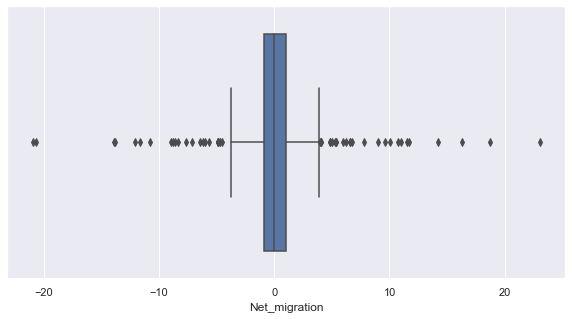

In [43]:
#IQR
plt.figure(figsize=(10,5))
sns.boxplot(countries.Net_migration)

In [44]:
#tudo que estiver neste intervalo não é considerado outlier
q1= countries.Net_migration.quantile(0.25)
q3 = countries.Net_migration.quantile(0.75)
iqr = q3 - q1
non_outlier_iqr = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
non_outlier_iqr

[-3.8149999999999995, 3.885]

In [45]:
#quantidade abaixo e acima
len(countries.Net_migration[(countries.Net_migration < non_outlier_iqr[0]) ])
len(countries.Net_migration[(countries.Net_migration > non_outlier_iqr[1]) ])

26

In [46]:
outlier_iqr = countries.Net_migration[(countries.Net_migration<non_outlier_iqr[0] )|
                                      (countries.Net_migration>non_outlier_iqr[1])]

In [47]:
# 22% dos dados são considerados outliers por esta técnica
print('Quantidade de outliers:' ,len(outlier_iqr))
print('Porcentagem % :' , round(len(outlier_iqr)/len(countries.Net_migration)*100,2))

Quantidade de outliers: 50
Porcentagem % : 22.03


In [48]:
#como existe 3 registros com Nan, estes campos serão preenchidos para completar a análise
Net_migration_semNAN = countries.Net_migration.fillna(value=0)

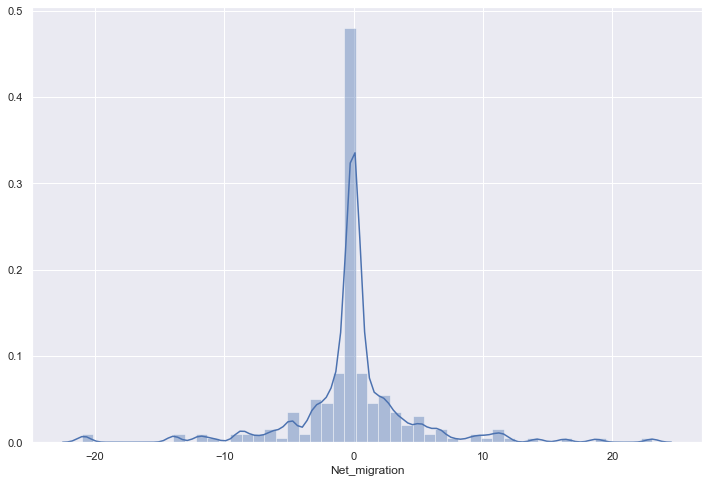

In [49]:
#Histograma
sns.distplot(Net_migration_semNAN)

In [50]:
#Pelo histograma uma forma de identificar os outliers é o dado estar fora do intervalo
#[media - k * std, media + k * std ], onde k é geralmente 1.5, 2, 2.5 ou 3
#pela analise visual, vamos considerar k=2.0
mean = Net_migration_semNAN.mean()
std = Net_migration_semNAN.std()
print(mean, std)

0.037621145374449334 4.856711857648491


In [51]:
non_outlier_hist = [mean - 2.0 * std, q1 + 2.0 * std]
non_outlier_hist

[-9.675802569922531, 8.785923715296981]

In [52]:
outlier_hist = Net_migration_semNAN[(Net_migration_semNAN<non_outlier_hist[0] )|
                                      (Net_migration_semNAN>non_outlier_hist[1])]
# 8% dos dados são considerados outliers por esta técnica
print('Quantidade de outliers:' ,len(outlier_hist))
print('Porcentagem % :' , round(len(outlier_hist)/len(Net_migration_semNAN)*100,2))

Quantidade de outliers: 18
Porcentagem % : 7.93


## Análise questão 6

In [53]:
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)

In [54]:
#Bunch é uma subclasse da classe DIC. Ele permite usar keys como atributos
type(newsgroup)

sklearn.utils.Bunch

In [55]:
#chaves do dataset
newsgroup.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [56]:
#forma de acessar os dados
newsgroup.data[0]

'From: rubin@cis.ohio-state.edu (Daniel J Rubin)\nSubject: Re: what to do with old 256k SIMMs?\nOrganization: The Ohio State University Dept. of Computer and Info. Science\nLines: 18\nNNTP-Posting-Host: diplodocus.cis.ohio-state.edu\n\n>>\tI was wondering if people had any good uses for old\n>>256k SIMMs.  I have a bunch of them for the Apple Mac\n>>and I know lots of other people do to.  I have tried to\n>>sell them but have gotten NO interest.\n\nHow hard would it be to somehow interface them to some of the popular \nMotorola microcontrollers.  I am a novice at microcontrollers, but I am\nstarting to get into them for some of my projects.  I have several 256k\nSIMMs laying around from upgraded Macs and if I could use them as "free"\nmemory in one or two of my projects that would be great.  One project that\ncomes to mind is a Caller ID device that would require quite a bit of RAM\nto store several hundered CID records etc...\n\n                                                        

In [57]:
#converte um coleção de documentos em uma matriz com o total de tokens
vectorizer = CountVectorizer(analyzer='word')
vectorizer_fit = vectorizer.fit_transform(newsgroup.data)

In [58]:
#A palavra phone esta no vetor na posição 19211. Lembrando que os indices em python iniciam com 0
vectorizer.vocabulary_['phone']

19211

In [59]:
#tamanho do vetor
vectorizer_fit.shape

(1773, 27335)

In [60]:
#quantidade de vezes que a palavra aparece
vectorizer_fit[:,19211].sum()

213

## Análise questão 7

In [61]:
tfid = TfidfVectorizer()
tfid_fit = tfid.fit_transform(newsgroup.data)

In [62]:
tfid.vocabulary_['phone']

19211

In [63]:
tfid_fit.shape

(1773, 27335)

In [64]:
#score dado pela quantidade de vezes que a palavra aparece. 
#Quanto menos aparecer maior o score
tfid_fit[:,19211].sum()

8.88774594667355

## Questão 1

Quais são as regiões (variável `Region`) presentes no _data set_? Retorne uma lista com as regiões únicas do _data set_ com os espaços à frente e atrás da string removidos (mas mantenha pontuação: ponto, hífen etc) e ordenadas em ordem alfabética.

In [65]:
def q1():
    return sorted(countries.Region.value_counts().index.tolist()) 
q1()

['ASIA (EX. NEAR EAST)',
 'BALTICS',
 'C.W. OF IND. STATES',
 'EASTERN EUROPE',
 'LATIN AMER. & CARIB',
 'NEAR EAST',
 'NORTHERN AFRICA',
 'NORTHERN AMERICA',
 'OCEANIA',
 'SUB-SAHARAN AFRICA',
 'WESTERN EUROPE']

## Questão 2

Discretizando a variável `Pop_density` em 10 intervalos com `KBinsDiscretizer`, seguindo o encode `ordinal` e estratégia `quantile`, quantos países se encontram acima do 90º percentil? Responda como um único escalar inteiro.

In [66]:
def q2():
    #Criação de variável que representa intevalos, semelhante ao pd.cut
    discretizer = preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
    discretizer.fit(countries[['Pop_density']])
    return int(sum(score_bins[:,0]>=9))
q2()

23

# Questão 3

Se codificarmos as variáveis `Region` e `Climate` usando _one-hot encoding_, quantos novos atributos seriam criados? Responda como um único escalar.

In [67]:
def q3():
    #preencher estes registros com 0
    countries[['Climate']] = countries[['Climate']].fillna(value=0)
    onehotencoder_Region = preprocessing.OneHotEncoder().fit(countries[['Region']])
    #necessário colocar parametro categories=auto para não juntar 1 e 1.5
    onehotencoder_Climate = preprocessing.OneHotEncoder(categories='auto').fit(countries[['Climate']])
    soma = len(onehotencoder_Region.categories_[0])+ len(onehotencoder_Climate.categories_[0])
    return soma
q3()

18

## Questão 4

Aplique o seguinte _pipeline_:

1. Preencha as variáveis do tipo `int64` e `float64` com suas respectivas medianas.
2. Padronize essas variáveis.

Após aplicado o _pipeline_ descrito acima aos dados (somente nas variáveis dos tipos especificados), aplique o mesmo _pipeline_ (ou `ColumnTransformer`) ao dado abaixo. Qual o valor da variável `Arable` após o _pipeline_? Responda como um único float arredondado para três casas decimais.

In [ ]:
test_country = [
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
]

In [68]:
def q4():
    pipeline = Pipeline(steps=[
    ("imputer_median", SimpleImputer(strategy="median")),
    ("standardscaler", preprocessing.StandardScaler())
    ])
    #comando único seria pipeline.fit_transform(countries_number)
    countries_number = countries.select_dtypes(include=[np.number])
    fit = pipeline.fit(countries_number)
    transf = fit.transform(countries_number)
    #aplica o pipeline para os dados fornecidos
    transf_test = pipeline.transform([test_country[2:]])
    ##retorna a posição (index) da coluna Arable e busca no vetor
    arable = transf_test[:, countries_number.columns.get_loc('Arable') ]
    return float(np.around(arable.item(),3))
q4()

-1.047

## Questão 5

Descubra o número de _outliers_ da variável `Net_migration` segundo o método do _boxplot_, ou seja, usando a lógica:

$$x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ é outlier}$$

que se encontram no grupo inferior e no grupo superior.

Você deveria remover da análise as observações consideradas _outliers_ segundo esse método? Responda como uma tupla de três elementos `(outliers_abaixo, outliers_acima, removeria?)` ((int, int, bool)).

In [69]:
def q5():
    #tudo que estiver neste intervalo não é considerado outlier
    q1= countries.Net_migration.quantile(0.25)
    q3 = countries.Net_migration.quantile(0.75)
    iqr = q3 - q1
    non_outlier_iqr = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
    #quantidade abaixo e quantidade acima.
    #analise indicou 30% de outlier, uma quantidade significativa que naão deve ser removida
    lower = len(countries.Net_migration[countries.Net_migration<non_outlier_iqr[0] ])
    upper = len(countries.Net_migration[countries.Net_migration>non_outlier_iqr[1] ])
    return (lower, upper, False)
q5()

(24, 26, False)

## Questão 6
Para as questões 6 e 7 utilize a biblioteca `fetch_20newsgroups` de datasets de test do `sklearn`

Considere carregar as seguintes categorias e o dataset `newsgroups`:

```
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)
```


Aplique `CountVectorizer` ao _data set_ `newsgroups` e descubra o número de vezes que a palavra _phone_ aparece no corpus. Responda como um único escalar.

In [70]:
def q6():
    categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
    newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)
    vectorizer = CountVectorizer(analyzer='word')
    vectorizer_fit = vectorizer.fit_transform(newsgroup.data)
    return int((vectorizer_fit[:,vectorizer.vocabulary_['phone']].sum()))
q6()

213

## Questão 7

Aplique `TfidfVectorizer` ao _data set_ `newsgroups` e descubra o TF-IDF da palavra _phone_. Responda como um único escalar arredondado para três casas decimais.

In [71]:
def q7():
    tfid = TfidfVectorizer()
    tfid_fit = tfid.fit_transform(newsgroup.data)
    return float(round(tfid_fit[:,tfid.vocabulary_['phone']].sum(),3))
q7()

8.888